In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

https://archive.ics.uci.edu/dataset/222/bank+marketing

https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset

# Notes

Heavy class imbalance in default and loan

# FUNCTIONS

All functions used in this project are in this section

In [2]:
#Read dataset, check for null and duplicates
def read_dataset(dataset):
    
    data = pd.read_csv(dataset)
    nrow = len(data.index)
    ncol = len(data.columns)

    print("The dataset contains", format(nrow, ",d"), "rows and", ncol, "columns.")
    
    #Check for null values
    if ((data.isna().sum()).sum()) > 0:
        print("There are null items in the dataset")
    else:
        print("There are no null items in the dataset")
        
    #Check for duplicates
    
    #col_names = ["Country", "Year", "Status"]
    #(data.duplicated(subset=col_names)).sum()

    if (data.duplicated().sum()) > 0:
        print("There are duplicates in the dataset")
    else:
        print("There are no duplicates in the dataset")
        
    return data



#Function to categorize data into numeric and categorical
def categorize_data(data):
    
    numeric=[]
    categorical=[]
    numeric_dtypes = ["int64", "int32", "float64", "float32"]

    for i in range (len(data.columns)):
        if data[data.columns[i]].dtype in numeric_dtypes:
            numeric.append(data.columns[i])
        else:
            categorical.append(data.columns[i])
            
    return numeric, categorical

    
#Function to check for outliers
def outliers_check(data, numeric):
    outliers_sum =[]

    for i in range(len(numeric_cols)):
        Q1 = data[numeric_cols[i]].quantile(0.25)
        Q3 = data[numeric_cols[i]].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (data[numeric_cols[i]] < (Q1 - 1.5 * IQR)) | (data[numeric_cols[i]] > (Q3 + 1.5 * IQR))
        print(numeric_cols[i], "",outliers.sum())
        outliers_sum.append(outliers.sum())

    return outliers.sum()


def remove_duplicates(data):
    duplicated_sum = data.duplicated().sum()
    if duplicated_sum == 0:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        return data
    else:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        data = data[~data.duplicated()]
        print("Duplicated rows have been removed")
        return data

    
    
def oneHotEncoding(data, categorical):

    encoder = OneHotEncoder(sparse=False, drop='first')  # 'drop' parameter removes one of the dummy variables to avoid multicollinearity

    encoded_data = encoder.fit_transform(data[categorical_cols])

    data_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

    data_final = pd.concat([data.drop(columns=categorical_cols), data_encoded], axis=1)

    return data_final

# EDA

In [3]:
data = read_dataset("bank.csv")

The dataset contains 11,162 rows and 17 columns.
There are no null items in the dataset
There are no duplicates in the dataset


In [4]:
pd.set_option('display.max_columns', None)

(data).head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [6]:
#Summary statistics of the dataset
data.describe()

age       balance           day      duration      campaign  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524     15.658036    371.993818      2.508421   
std       11.913369   3225.413326      8.420740    347.128386      2.722077   
min       18.000000  -6847.000000      1.000000      2.000000      1.000000   
25%       32.000000    122.000000      8.000000    138.000000      1.000000   
50%       39.000000    550.000000     15.000000    255.000000      2.000000   
75%       49.000000   1708.000000     22.000000    496.000000      3.000000   
max       95.000000  81204.000000     31.000000   3881.000000     63.000000   

              pdays      previous  
count  11162.000000  11162.000000  
mean      51.330407      0.832557  
std      108.758282      2.292007  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       20.750000      1.000000  
max      854.000000     58.000000

In [7]:
#Class imbalance
data['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

In [8]:
#Categorize data into numeric and categorical
numeric_cols, categorical_cols = categorize_data(data)

# Visualisations

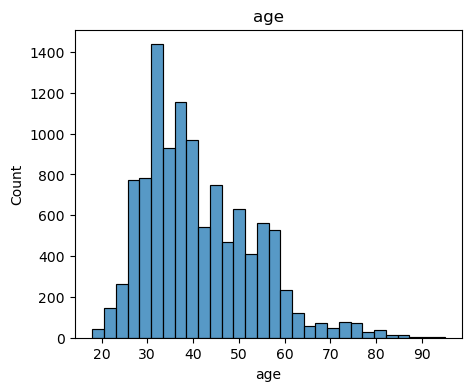

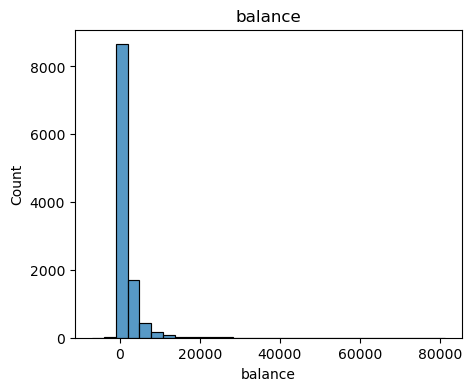

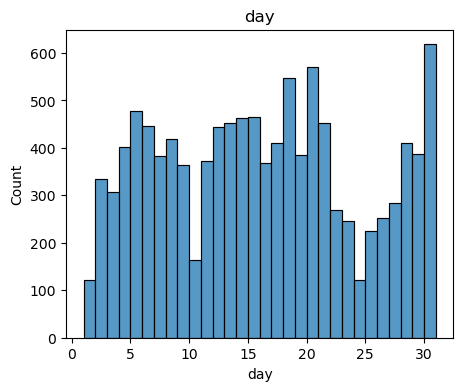

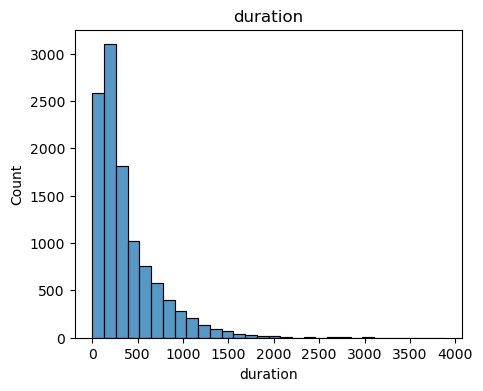

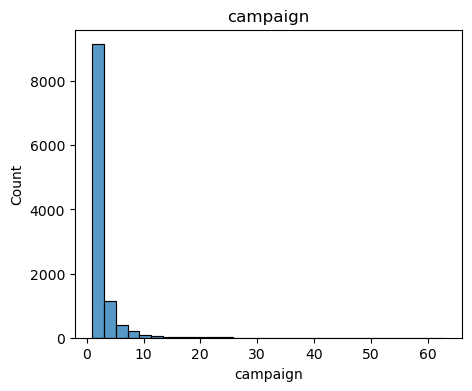

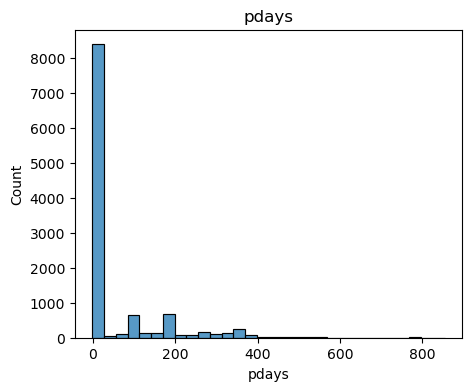

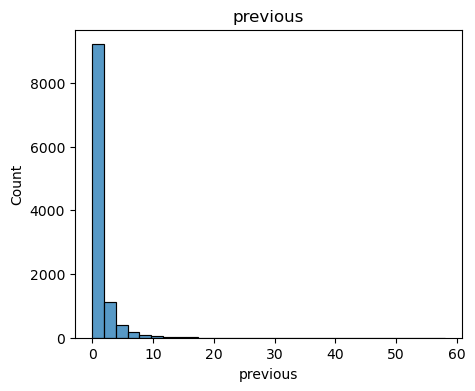

In [9]:
#Check distributions of numeric columns
for i in range (len(numeric_cols)):
    plt.figure(figsize=(5,4))
    sns.histplot(data[numeric_cols[i]], bins=30)
    plt.title(numeric_cols[i])

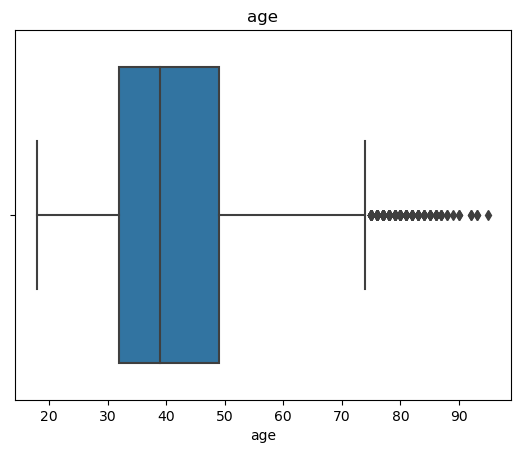

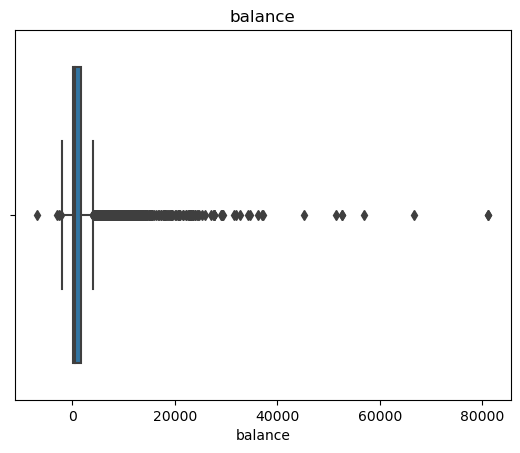

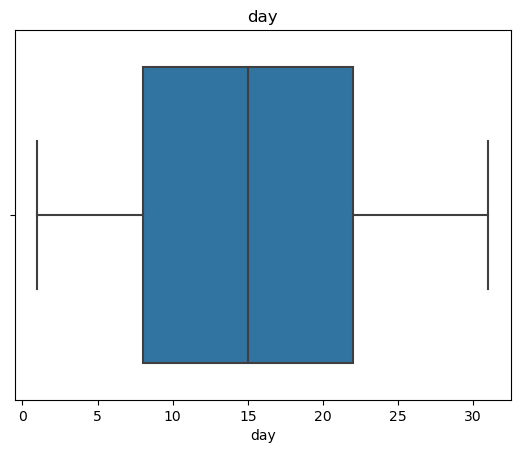

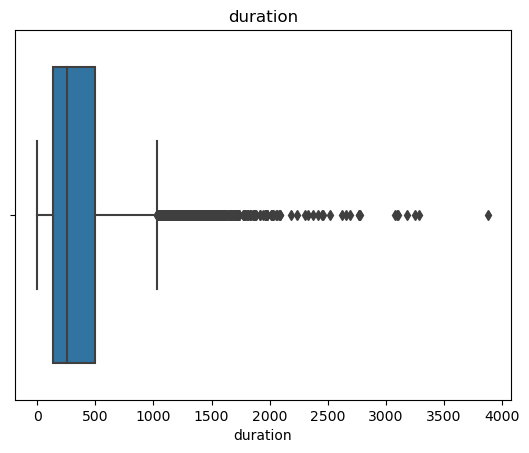

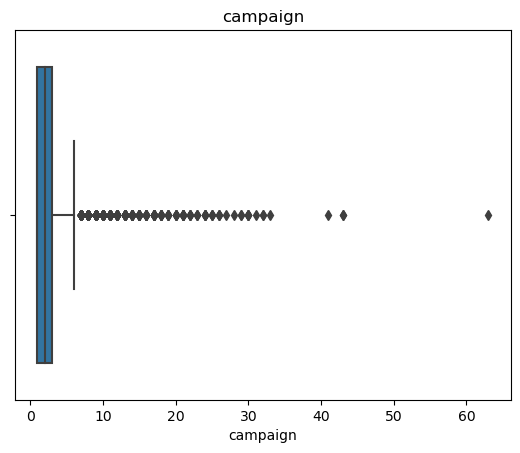

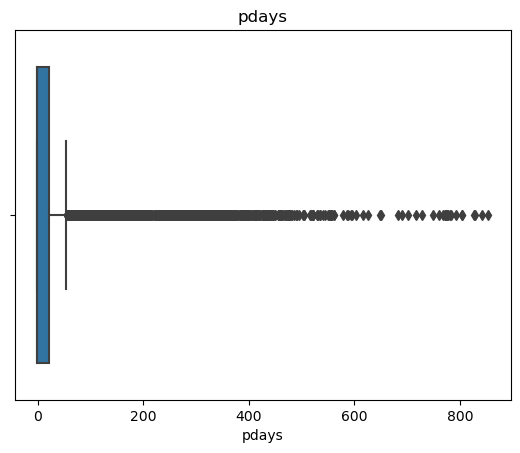

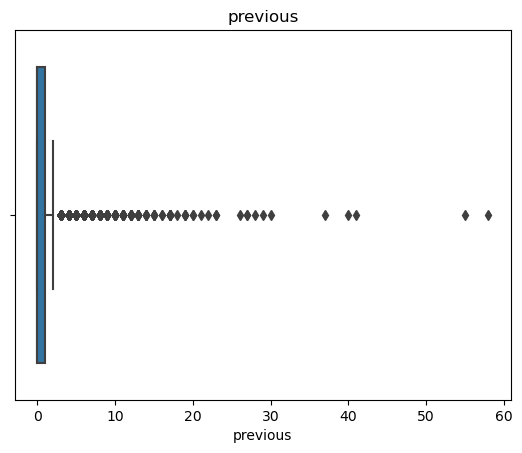

In [18]:
#Box plots for numeric columns
for i in range (len(numeric_cols)):
    plt.figure()
    plt.title(numeric_cols[i])
    sns.boxplot(x=data[numeric_cols[i]], data=data)

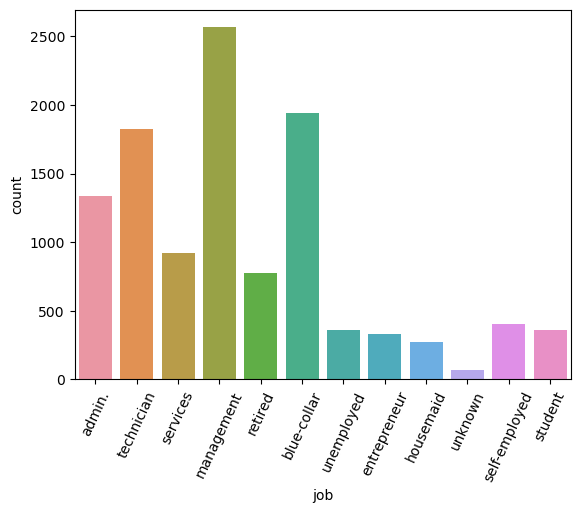

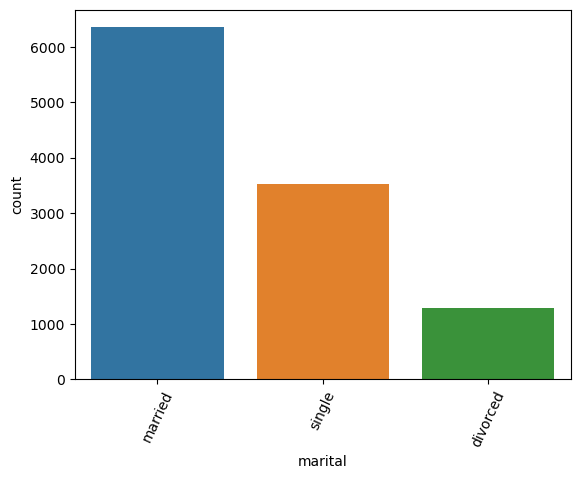

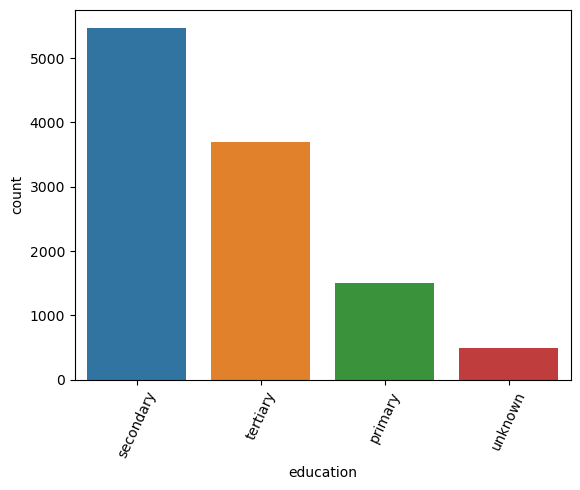

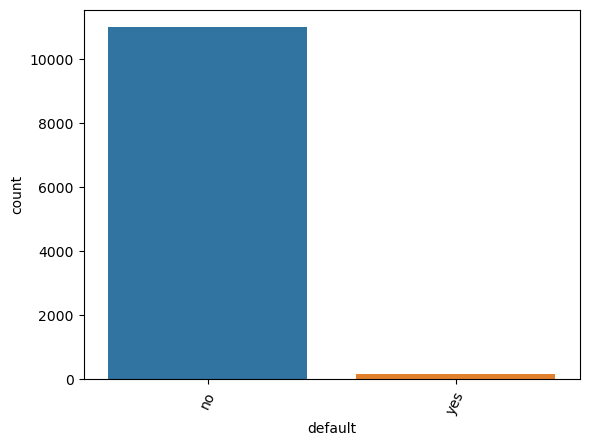

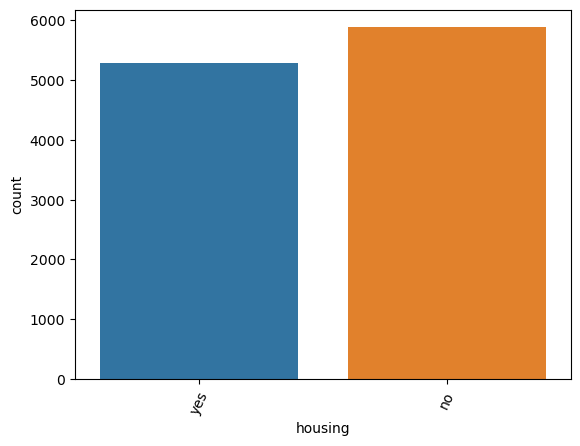

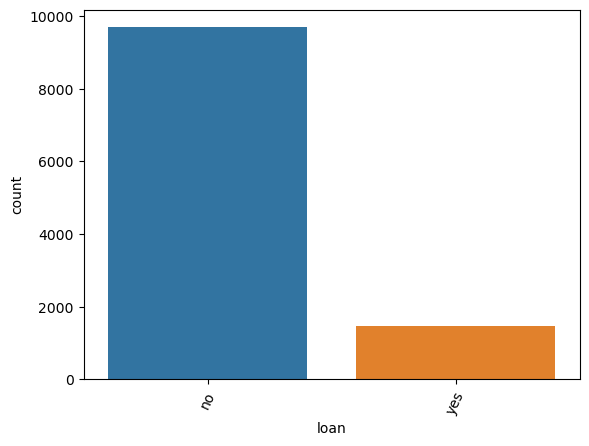

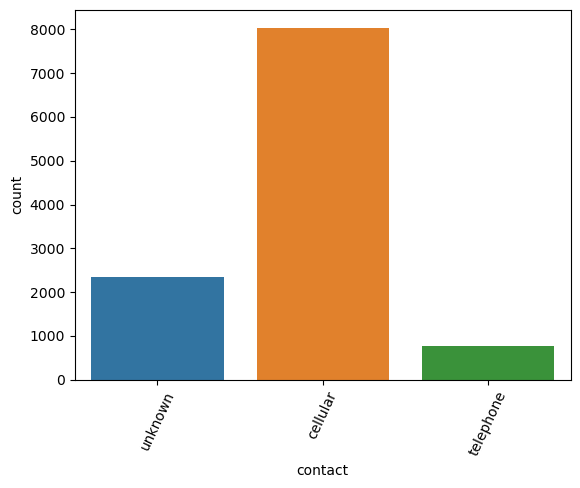

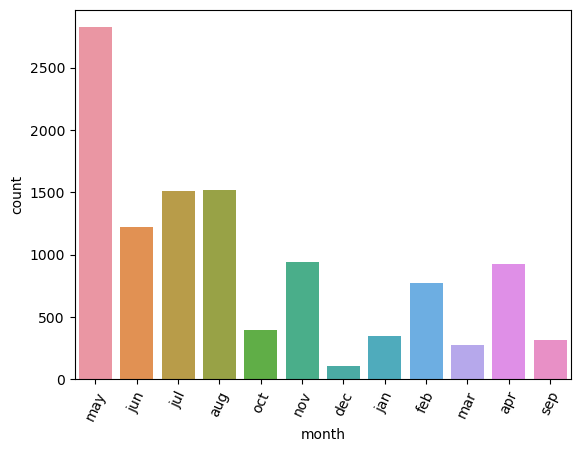

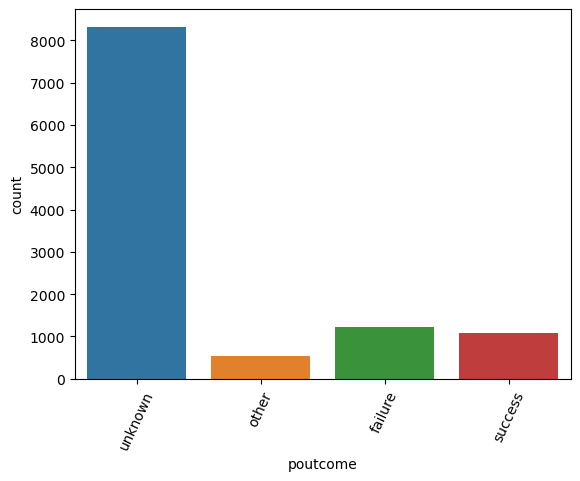

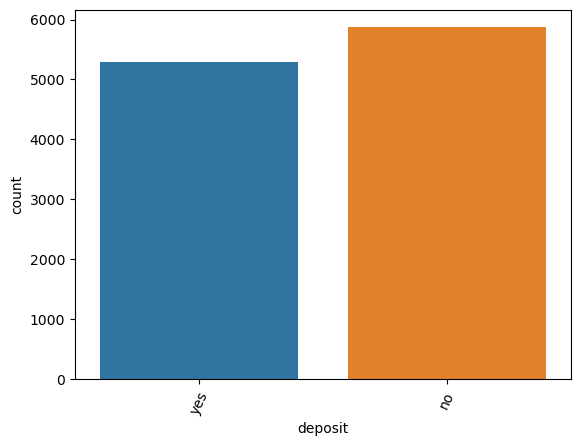

In [14]:
#Bar plots for categorical columns
for i in range (len(categorical_cols)):
    plt.figure()
    sns.countplot(x=data[categorical_cols[i]], data=data)
    plt.xticks(rotation=65) 

In [15]:
#Check for outliers
outliers = outliers_check(data, numeric_cols)

age  171
balance  1055
day  0
duration  636
campaign  601
pdays  2750
previous  1258


# Correlation and Dimensionality Reduction

In [13]:
data.corr()

C:\Users\amych\AppData\Local\Temp\ipykernel_1748\2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


age   balance       day  duration  campaign     pdays  previous
age       1.000000  0.112300 -0.000762  0.000189 -0.005278  0.002774  0.020169
balance   0.112300  1.000000  0.010467  0.022436 -0.013894  0.017411  0.030805
day      -0.000762  0.010467  1.000000 -0.018511  0.137007 -0.077232 -0.058981
duration  0.000189  0.022436 -0.018511  1.000000 -0.041557 -0.027392 -0.026716
campaign -0.005278 -0.013894  0.137007 -0.041557  1.000000 -0.102726 -0.049699
pdays     0.002774  0.017411 -0.077232 -0.027392 -0.102726  1.000000  0.507272
previous  0.020169  0.030805 -0.058981 -0.026716 -0.049699  0.507272  1.000000

# One Hot Encoding

In [16]:
#One hot encoding

data_encoded = oneHotEncoding(data_cleaned, categorical_cols)

data_encoded.head()

NameError: name 'data_cleaned' is not defined

In [13]:
data_encoded.shape

(58592, 89)

In [14]:
#Randomise the dataset

data_sampled = data_encoded.sample(frac=1, random_state=42)

#All features except the target are assigned to 'X'
X = data_sampled.drop("is_claim", axis=1)

#Target feature is assigned to 'Y'
Y = data_sampled["is_claim"]

data_sampled.head()

policy_tenure  age_of_car  age_of_policyholder  population_density  \
29918       0.285690        0.05             0.509615                4076   
5034        0.122252        0.05             0.403846                8794   
38100       0.213020        0.03             0.365385                4076   
17050       0.036614        0.00             0.432692               17804   
35146       1.041438        0.04             0.576923                8794   

       make  airbags  displacement  cylinder  gear_box  turning_radius  \
29918     5        2          1498         4         5             4.9   
5034      1        2          1197         4         5             4.8   
38100     3        6          1493         4         6             5.2   
17050     1        2           796         3         5             4.6   
35146     1        2          1197         4         5             4.8   

       length  width  height  gross_weight  ncap_rating  is_claim  \
29918    3995   1695    1501          1051            4         0   
5034     3845   1735    1530          1335            2         0   
38100    4300   1790    1635          1720            3         0   
17050    3445   1515    1475          1185            0         0   
35146    3845   1735    1530          1335            2         0   

       max_torque_nm  max_torque_rpm  max_power_bhp  max_power_rpm  \
29918          200.0            1750          97.89           3600   
5034           113.0            4400          88.50           6000   
38100          250.0            2750         113.45           4000   
17050           60.0            3500          40.36           6000   
35146          113.0            4400          88.50           6000   

       area_cluster_C10  area_cluster_C11  area_cluster_C12  area_cluster_C13  \
29918               0.0               0.0               0.0               0.0   
5034                0.0               0.0               0.0               0.0   
38100               0.0               0.0               0.0               0.0   
17050               0.0               0.0               0.0               0.0   
35146               0.0               0.0               0.0               0.0   

       area_cluster_C14  area_cluster_C15  area_cluster_C16  area_cluster_C17  \
29918               0.0               0.0               0.0               0.0   
5034                0.0               0.0               0.0               0.0   
38100               0.0               0.0               0.0               0.0   
17050               0.0               0.0               0.0               0.0   
35146               0.0               0.0               0.0               0.0   

       area_cluster_C18  area_cluster_C19  area_cluster_C2  area_cluster_C20  \
29918               0.0               0.0              0.0               0.0   
5034                0.0               0.0              0.0               0.0   
38100               0.0               0.0              0.0               0.0   
17050               0.0               0.0              0.0               0.0   
35146               0.0               0.0              0.0               0.0   

       area_cluster_C21  area_cluster_C22  area_cluster_C3  area_cluster_C4  \
29918               0.0               0.0              1.0              0.0   
5034                0.0               0.0              0.0              0.0   
38100               0.0               0.0              1.0              0.0   
17050               0.0               0.0              0.0              0.0   
35146               0.0               0.0              0.0              0.0   

       area_cluster_C5  area_cluster_C6  area_cluster_C7  area_cluster_C8  \
29918              0.0              0.0              0.0              0.0   
5034               0.0              0.0              0.0              1.0   
38100              0.0              0.0              0.0              0.0   
17050              0.0   

# Dataset Rebalancing

Undersampling and Oversampling sampling methods were used for modelling. Results for both methods will be compared to the result of modelling without any sampling method.

Rebalancing is done on the training set only.

In [15]:
#split into train and test

xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.3, random_state=None)

In [16]:
#Undersampling

undersampling = RandomUnderSampler(random_state=42)

xtrain_undersampled, ytrain_undersampled = undersampling.fit_resample(xtrain, ytrain)

xtrain_undersampled.shape

(5106, 88)

In [17]:
#Oversampling

oversampling = RandomOverSampler(random_state=42)

xtrain_oversampled, ytrain_oversampled = oversampling.fit_resample(xtrain, ytrain)

xtrain_oversampled.shape

(76922, 88)

In [18]:
#Target column is now balanced

print("Undersampled:\n", ytrain_undersampled.value_counts())

print("\nOversampled:\n", ytrain_oversampled.value_counts())

Undersampled:
 0    2553
1    2553
Name: is_claim, dtype: int64

Oversampled:
 0    38461
1    38461
Name: is_claim, dtype: int64


# Dataset Scaling

Both oversampled and undersampled datasets are scaled and PCA will be applied to them

In [20]:
#Scaling the data - undersampled dataset

scaler_undersampled = StandardScaler()
xtrain_scaled_undersampled = scaler_undersampled.fit_transform(xtrain_undersampled)
xtest_scaled_undersampled = scaler_undersampled.fit_transform(xtest)


xtrain_scaled_undersampled.shape

(5106, 88)

In [22]:
#Scaling the data - oversampled dataset

scaler_oversampled = StandardScaler()
xtrain_scaled_oversampled = scaler_oversampled.fit_transform(xtrain_oversampled)
xtest_scaled_oversampled = scaler_oversampled.fit_transform(xtest)


xtrain_scaled_oversampled.shape

(76922, 88)

# Dimensionality Reduction Using Principal Component Analysis

In [24]:
#PCA - oversampled dataset

pca_undersampled = PCA(84)

xtrain_pca_undersampled = pca_undersampled.fit_transform(xtrain_scaled_undersampled)

xtest_pca_undersampled = pca_undersampled.fit_transform(xtest_scaled_undersampled)

#pca.explained_variance_ratio_

In [26]:
#PCA - oversampled dataset

pca_oversampled = PCA(84)

xtrain_pca_oversampled = pca_oversampled.fit_transform(xtrain_scaled_oversampled)

xtest_pca_oversampled = pca_oversampled.fit_transform(xtest_scaled_oversampled)

#pca.explained_variance_ratio_

# Modelling

Modelling will be done on the dataset after scaling, and the dataset after PCA

In [27]:
#Logistic regresison model - undersampled dataset

reg_undersampled = LogisticRegression()
reg_undersampled.fit(xtrain_pca_undersampled, ytrain_undersampled)

LogisticRegression()

In [28]:
#Logistic regresison model - oversampled dataset

reg_oversampled = LogisticRegression()
reg_oversampled.fit(xtrain_pca_oversampled, ytrain_oversampled)

LogisticRegression()

In [29]:
#Logistic regresison model - no sampling, scaling or PCA done on this dataset

reg = LogisticRegression()
reg.fit(xtrain, ytrain)

LogisticRegression()

In [30]:
#Predictions

predictions_undersampled = reg_undersampled.predict(xtest_pca_undersampled)

predictions_oversampled = reg_oversampled.predict(xtest_pca_oversampled)

predictions = reg.predict(xtest)

# Evaluations

In [31]:
accuracy_undersampled = accuracy_score(ytest, predictions_undersampled)
accuracy_oversampled = accuracy_score(ytest, predictions_oversampled)
accuracy = accuracy_score(ytest, predictions)

print("The following are results of the logistic regression model and different sampling methods\n")
print("Undersampling:", accuracy_undersampled)
print("Oversampling:", accuracy_oversampled)
print("No sampling:", accuracy)

The following are results of the logistic regression model and different sampling methods

Undersampling: 0.5204232563431562
Oversampling: 0.5033564683126636
No sampling: 0.9320172943452042


In [32]:
print(confusion_matrix(ytest, predictions_undersampled))

[[8454 7929]
 [ 501  694]]


In [33]:
print(confusion_matrix(ytest, predictions_oversampled))

[[8161 8222]
 [ 508  687]]


In [34]:
print(confusion_matrix(ytest, predictions))

[[16383     0]
 [ 1195     0]]
